In [1]:
from keras.layers import Dense,Conv2D,Reshape,Flatten,Conv2DTranspose,LeakyReLU,Dropout,BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot
from numpy import zeros,ones
from numpy.random import randint,randn
from keras.datasets.cifar10 import load_data
import numpy as np
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
 

Using TensorFlow backend.


In [0]:
tensorboard = TensorBoard(
  log_dir='drive/My Drive/dcgan_logs',
  histogram_freq=0,
  batch_size=100,
  write_graph=True,
  write_grads=True
)



In [0]:
def discriminator_model():
  model= Sequential()
  model.add(Conv2D(64,kernel_size=3,strides=1,padding='same',input_shape=(32,32,3)))
  model.add(LeakyReLU(0.3))
  model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Conv2D(256,kernel_size=3,strides=2,padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Conv2D(512,kernel_size=3,strides=2,padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(0.0004, beta_1=0.5), metrics=['accuracy'])
  return model

In [4]:
discriminator=discriminator_model()
discriminator.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
_____________________________________

In [0]:
def generator_model():
  model=Sequential()
  model.add(Dense(4*4*512,input_dim=100))
  model.add(LeakyReLU(alpha=0.3))
  model.add(Reshape((4, 4, 512)))
  model.add(Conv2DTranspose(256,kernel_size=4,strides=2,padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Conv2DTranspose(64,kernel_size=4,strides=2,padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Conv2D(3, kernel_size=3,strides=1, activation='tanh', padding='same'))
  return model


In [6]:
generator=generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)      

In [0]:
def gan_model(discriminator,generator):
  discriminator.trainable=False
  model=Sequential()
  model.add(generator)
  model.add(discriminator)
  model.compile(loss='binary_crossentropy', optimizer=Adam(0.0004, beta_1=0.5), metrics=['accuracy'])
  return model

In [8]:
gan=gan_model(discriminator,generator)
gan.summary()
tensorboard.set_model(gan)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 32, 32, 3)         3582083   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1559169   
Total params: 5,141,252
Trainable params: 3,582,083
Non-trainable params: 1,559,169
_________________________________________________________________










In [0]:
def load_and_normalize():
  (x_train, y_train), (x_test, y_test) = load_data()
  print(x_train.shape)
  
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train=(x_train-127.5)/127.5
  x_test=(x_test-127.5)/127.5
#  print(x_train.shape)
  return x_train,x_test

In [0]:
def data_for_discriminator(data,batch_size):
  random = randint(0,data.shape[0] ,int(batch_size/2))
  real_f = data[[random]]
  
  real_l = ones((int(batch_size/2), 1))
  input_dims=randn(100*int(batch_size/2))
  input_dims = input_dims.reshape(int(batch_size/2), 100)
  fake_f = generator.predict(input_dims)
  fake_l = zeros((int(batch_size/2), 1))
#  print(real_f.shape)
#  print(fake_f.shape)
  
  train_disx=np.concatenate((real_f,fake_f),axis=0)
  train_disy=np.concatenate((real_l,fake_l),axis=0)

  return train_disx,train_disy

In [0]:
def data_for_gan(batch_size):
  input_dims=randn(100*batch_size)
  train_gan_x= input_dims.reshape(batch_size, 100)
  train_gan_y=ones((batch_size, 1))
  return train_gan_x,train_gan_y

In [0]:
def data_for_img_generation(generator,num_images):
  input_dims=randn(100*num_images)
  input_dims = input_dims.reshape(num_images,100)
  data_x = generator.predict(input_dims)
  data_y = zeros((num_images, 1))
  return data_x, data_y


In [0]:
def plot_final(n=8):
  x_fake, y_fake = data_for_img_generation(generator, n*n)
  x_fake = (x_fake + 1) / 2.0

  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(x_fake[i])
  filename = 'generated_plot_final.png' 
  pyplot.plot(filename)
  pyplot.close()

In [0]:
# def fid_cals(images1,images2):
# # scale an array of images to a new size
def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
  return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = numpy.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid



In [0]:
def fid_check(epoch, generator, discriminator, dataset, latent_dim, num_images=1000):
	
#   filename = 'drive/My Drive/models/generator_model_%03d.h5' % (epoch+1)
#   generator.save(filename)
#   filename2 = 'drive/My Drive/models/discriminator_model_%03d.h5' % (epoch+1)
#   discriminator.save(filename2)
#   filename3 = 'drive/My Drive/models/gan_model_%03d.h5' % (epoch+1)
#   gan.save(filename3)

  x_fake, y_fake = data_for_img_generation(generator, num_images)

  model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
  images1, y_fake = data_for_img_generation(generator, 1200)
  (_, _), (images2, _) = cifar10.load_data()
  images2=images2[:1200]
  images2=(images2-127.5)/127.2 
  images1 = images1.astype('float32')
  images2 = images2.astype('float32')
  # resize images
  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  print('Scaled', images1.shape, images2.shape)
  # pre-process images
  #   images1 = preprocess_input(images1)
  #   images2 = preprocess_input(images2)
  # calculate fid
  fid = calculate_fid(model, images1, images2)
  print('FID: %.3f' % fid)


In [0]:
def train_model(discriminator,generator,gan,batch_size,data,epochs=100):
  bat_per_epo = int(data.shape[0] / batch_size)
  print(bat_per_epo)
  epoch_arr=np.zeros((100,1))
  dis_loss=np.zeros((100,1))
  gen_loss=np.zeros((100,1))
  for i in range(epochs):
		# enumerate batches over the training set
    
    for j in range(bat_per_epo):
      epoch_arr=np.append(epoch_arr,i)
      train_disx,train_disy=data_for_discriminator(data,batch_size)
      d_loss,d=discriminator.train_on_batch(train_disx,train_disy)
      dis_loss=np.append(dis_loss,d_loss)
      train_ganx,train_gany=data_for_gan(batch_size)
      g_loss,f=gan.train_on_batch(train_ganx,train_gany)
      gen_loss=np.append(gen_loss,g_loss)
    #  print(i+1, j+1, bat_per_epo, d_loss, g_loss)
    if (i+1) % 2 == 0:
      fid_check(i+1,generator,discriminator,gan,data,100)    

    tensorboard.on_epoch_end(epochs, {"D_loss":d_loss,"GAN_loss":g_loss})
  pyplot.plot(epoch_arr,dis_loss)
  pyplot.plot(epoch_arr,gen_loss)
  


In [17]:
data,_ = load_and_normalize()

(50000, 32, 32, 3)


In [18]:
train_model(discriminator,generator, gan,100, data)

500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'






87916544/87910968 [==============================] - 1s 0us/step
Scaled (1200, 299, 299, 3) (1200, 299, 299, 3)
FID: 195.765
Scaled (1200, 299, 299, 3) (1200, 299, 299, 3)


KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Scaled (1200, 299, 299, 3) (1200, 299, 299, 3)
FID: 73.340


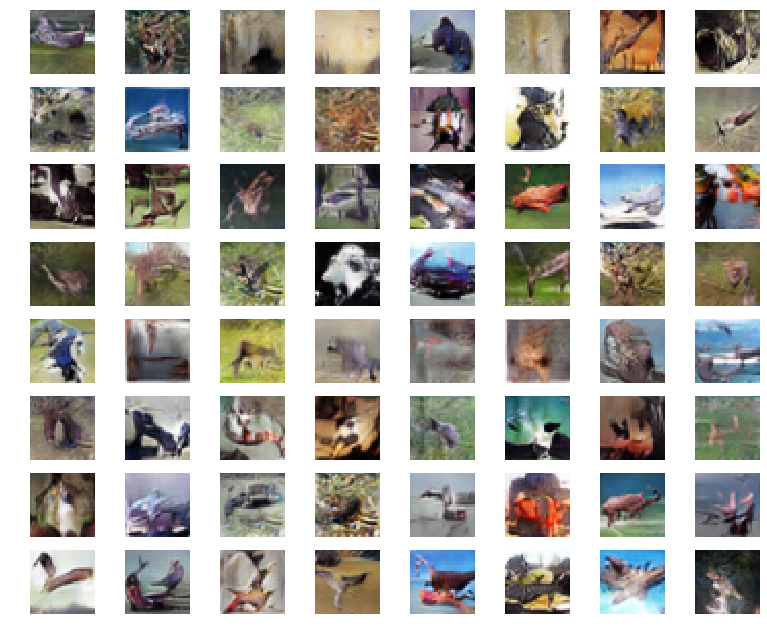

In [25]:
import numpy as np
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from numpy import loadtxt
from keras.models import load_model
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

def data_for_img_generation(generator,num_images):
  input_dims=randn(100*num_images)
  input_dims = input_dims.reshape(num_images,100)
  data_x = generator.predict(input_dims)
  data_y = zeros((num_images, 1))
  return data_x, data_y
def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
  return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = numpy.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid
 

generator = load_model('generator_model_101.h5')

#x_fake, y_fake = data_for_img_generation(generator,1200)

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
images1, y_fake = data_for_img_generation(generator, 1200)
(_, _), (images2, _) = cifar10.load_data()
images2=images2[:1200]
images2=(images2-127.5)/127.2 
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
#   images1 = preprocess_input(images1)
#   images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

x_fake, y_fake = data_for_img_generation(generator, 64)
x_fake = (x_fake + 1) / 2.0

for i in range(8 * 8):
  pyplot.subplot(8, 8, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(x_fake[i])
filename = 'generated_plot_final.png' 
pyplot.plot(filename)
